#Non-negative Matrix Factorization

##Overview

<a href='https://en.wikipedia.org/wiki/Non-negative_matrix_factorization'>Non-negative matrix factorization (NMF)</a> is an algorithm in linear algebra, which can also be <a href='https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#Clustering_property'>used for unsupervised clustering</a>. The idea is that we can start with an $n \times f$ matrix $V$ containing only non-negative values, in which each row represents an observation and each column represents a feature (in this case, a word), and decompose it into the product of an $n \times c$ matrix $W$ and a $c \times f$ matrix $H$ such that $WH \approx V$. (Typically, we would choose $c \ll \min(n,f)$ for clustering.) The following image (taken from Wikipedia) illustrates this, for the case where $n=4$, $f=6$, and $c=2$:

<img src='https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png'>

In particular, this can work as an unsupervised clustering algorithm: if we use a training data matrix $V$ and let $c$ be the number of clusters we want, then the $n \times c$ matrix $W$ includes a row of $c$ values for each document in the dataset, and each of those $c$ values represents how well the document fits into the corresponding cluster. (So, the element in row $i$ and column $j$ of $W$ represents how well document $i$ fits into cluster $j$.) Similarly, each column of the $c \times f$ matrix $H$ tells us how well each word in the vocabulary matches each cluster; we can use this to analyze the most important words for each cluster.

In this notebook, we use an NMF algorithm from scikit-learn, which can train an NMF fit on a training data matrix and use that to predict clusters for test data. (More technically, training the NMF model on an $n_{\text{train}} \times f$ training data matrix $V_{\text{train}}$ gives us an $n_{\text{train}} \times c$ matrix $W_{\text{train}}$ and an $c \times f$ matrix $H_{\text{train}}$ such that $W_{\text{train}} \times H_{\text{train}} \approx V_{\text{train}}$. This fit can be used to take an $n_{\text{test}} \times f$ test data matrix $V_{\text{test}}$ and produce a corresponding $n_{\text{test}} \times c$ matrix $W_{\text{test}}$, such that $W_{\text{test}} \times H_{\text{train}} \approx V_{\text{test}}$. Each column of $H_{\text{train}}$ tell us how well a particular word matches each of the $c$ clusters, and each row of $W_{\text{test}}$ tell us how well a particular test observation falls into each cluster.)

Although the NMF clustering method was not taught in class, we read about it and decided to try it when Max's resident tutor suggested it as a topic clustering technique for text analysis. Since NMF is implemented in scikit-learn, we were able to use it conveniently to cluster topic areas for cases.

### Summary of Findings
Overall, the NMF model is reasonably useful, though it is not nearly as accurate as some of the supervised models like Naive Bayes and SVM. The accuracy rate (relative to the Supreme Court Database topic area assignments) is roughly 50% within the training data itself, and around 47% for the test data when we use cross-validation to find the optimal parameter values. There are a few specific mistakes that the NMF algorithm tends to make extremely often (e.g. wrongly classifying federal taxation cases as economic activity instead), which significantly lower the accuracy rate. For this reason, this is not our best model, though it looked successful enough to warrant an in-depth explanation.

Although the NMF model was not our best, it is encouraging and interesting to see that an unsupervised algorithm was able to produce reasonably accurate results without using the Supreme Court Database data to compute the fit.

In [21]:
%matplotlib inline
import numpy as np
import sklearn.decomposition
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import bottleneck as bn
import itertools
from sklearn.cross_validation import KFold
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

###Multi-Purpose Functions for Evaluating Models
We can start by defining a couple of generally useful functions to evaluate the correctness of any given set of predictions.

In [2]:
# computes % accuracy rate of predictions, given a vector of predicted categories and a vector of actual categories
def accuracy(predicted,actual):
    # boolean array of Trues for correct predictions and Falses for incorrect predictions
    correct = map(lambda (c1,c2) : c1==c2, zip(predicted,actual))
    return float(sum(correct)) / len(correct)

Another way to measure the success of an unsupervised algorithm is the Rand Index, which was discussed in lecture. We refer to a pair of documents as a true positive ($tp$) if the two documents end up in the same cluster correctly, a true negative ($tn$) if the documents end up in different clusters correctly, a false positive ($fp$) if the documents are placed in the same cluster but should have been in different clusters, and a false negative ($fn$) if the documents are placed in different clusters but should have been in the same cluster.

The Rand Index (measuring the similarity between the NMF clustering and the SCDB categories) is defined as $\frac{tp+tn}{tp+tn+fp+fn}$. This is a useful measure of the quality of an unsupervised algorithm like NMF or k-means; accuracy is harder to interpret exactly because unsupervised algorithm does not use the training set categories to generate clusters.

In [3]:
# computes the Rand Index, given a vector of predicted categories and a vector of actual categories
def rand_index(predicted,actual):
    # use itertools to create pairs of documents, using the NMF clusters and SCDB categories
    cluster_pairs_pred = itertools.product(predicted,predicted)
    cluster_pairs_actual = itertools.product(actual,actual)
    # loop through all document pairs to compute tp, tn, fp, and fn
    (tp,tn,fp,fn) = 0, 0, 0, 0
    for pair1,pair2 in zip(cluster_pairs_pred, cluster_pairs_actual):
        if (pair1[0]==pair1[1]):
            if (pair2[0]==pair2[1]):
                tp += 1
            else:
                fp += 1
        else:
            if (pair2[0]==pair2[1]):
                fn += 1
            else:
                tn += 1
    
    # compute and output Rand Index using formula from above
    rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
    return rand_index_train

##Fitting Noun Model with Training Data

We'll start by fitting a model that only uses nouns, with the training data. To start with, we read in the matrix of noun training data, and apply a <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf">TF-IDF</a> (term frequency-inverse document frequency) transformation, which places a lower weight on words that show up very frequently across all of the documents (e.g. 'case' and 'court'). This enables more meaningful clustering, by downweighting words that couldn't be used to discriminate between topics very effectively.

In [4]:
%%time
# read in training data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 39 s


Next, we can fit an NMF model on the matrix computed above. For evaluating the NMF method initially, we can just use 14 components, since the Supreme Court Database (SCDB) uses 14 categories for its cases.

To assign a case to a cluster, we look at the the row of the `W` matrix corresponding to that case; this $1 \times 14$ row contains a coefficient corresponding to how well the case corresponds to each one of the 14 clusters. We assign the case to a cluster by choosing the highest coefficient in that row.
Then, we can construct a list called `clusters` that contains the cluster assignments for each case.

In [5]:
%%time
# compute NMF fit
NMF_fit = sklearn.decomposition.NMF(n_components=14, init='nndsvda').fit(noun_train_mat)
H = NMF_fit.components_
W = NMF_fit.transform(noun_train_mat)
# list of cluster assignments for the cases
clusters = map(np.argmax, W)
# list of the documents in each cluster
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]

Wall time: 1min 12s


C:\Users\Madhu\Anaconda\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


In [6]:
# classify each document into the category that fits it best
print 'Number of documents per category:', [sum([x==i for x in clusters]) for i in range(14)]

Number of documents per category: [121, 83, 72, 35, 118, 61, 93, 25, 38, 78, 76, 72, 52, 163]


###Key Words for Each Cluster

Using the clusters from above, we can use the `H` matrix to find out which words are the strongest predictors for each cluster. In this case, for each of the 14 rows of `H` we output the words corresponding to the 5 largest elements of that row, to understand the 5 words that best represent the corresponding cluster.

In [7]:
# load noun vocab from csv
noun_vocab = np.loadtxt("noun_vocab.csv", delimiter=",", dtype="str")
noun_vocab = [(int(i),j) for i,j in noun_vocab]
id2noun = dict(noun_vocab)

In [8]:
# find and output the 5 most important words for each category
num_best = 5
best_indices = map(lambda v : list(bn.argpartsort(-v,num_best)[0:num_best]), H)
best_words = [[id2noun[i] for i in lst] for lst in best_indices]
best_words

[['claim', 'appeal', 'district', 'court', 'jurisdiction'],
 ['labor', 'union', 'employee', 'board', 'employer'],
 ['tax', 'property', 'income', 'revenue', 'state'],
 ['student', 'board', 'school', 'plan', 'education'],
 ['plan', 'benefit', 'security', 'act', 'employee'],
 ['land', 'water', 'act', 'tribe', 'reservation'],
 ['trial', 'court', 'counsel', 'petitioner', 'state'],
 ['decree', 'master', 'orig ', 'u s ', 'entry'],
 ['alien', 'immigration', 'attorney', 'deportation', 'general'],
 ['gas', 'commission', 'commerce', 'carrier', 'price'],
 ['jury', 'trial', 'evidence', 'verdict', 'petitioner'],
 ['conviction', 'sentence', 'punishment', 'offense', 'crime'],
 ['search', 'warrant', 'officer', 'police', 'respondent'],
 ['state', 'opinion', 'amendment', 'law', 'post']]

These word lists are very meaningful. For example, the list `['labor', 'union', 'employee', 'board', 'employer']` clearly corresponds to cases involving unions and corporate law, while `['jury', 'trial', 'evidence', 'verdict', 'petitioner']` relates to judicial issues and `['student', 'board', 'school', 'plan', 'education']` corresponds to education-related cases. The fact that the word lists correspond to logically meaningful categories lends some credence to this model, though we will evaluate it much more rigorously below.

###Comparing with Supreme Court Database's Topic Areas

For now, we have been using an unsupervised algorithm that ignores the Supreme Court Database data altogether. To analyze and evaluate the performance of the algorithm, we need to include the data from the Supreme Court Database, which provides a category for each Supreme Court case.

In [9]:
# read in SC Database's issue areas from csv
train_issue_areas = np.loadtxt("train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
train_issue_areas = train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in train_issue_areas]) for i in range(14)]

Number of documents per category: [238, 186, 84, 43, 10, 9, 56, 234, 126, 57, 10, 30, 4, 0]


These are the 14 topic areas that the Supreme Court Database uses, in order.

In [10]:
topic_areas = ['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process', 'Privacy', 'Attorneys', 'Unions',
               'Economic Activity', 'Judicial Power', 'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
               'Private Action']

The unsupervised NMF algorithm has given us 14 clusters, but these 14 clusters don't map perfectly to the 14 SCDB clusters. We need a way to take the NMF cluster assignment for any particular case and convert it into the SCDB category that fits the case best. In particular, we need a way to map each NMF cluster to a particular SCDB category. There are multiple ways to do this, which are examined below.

####Assignment method 1: use the cluster assignments computed above to find the best SCDB category match
This method works as follows: For each NMF cluster from above, assign that cluster to the SCDB category that has the most cases in common with the NMF cluster.

We construct an `assignments` array, such that if `assignments[i]==j`, then NMF cluster `i` gets mapped to SCDB category `j`. Note that this is not a one-to-one mapping; in other words, multiple NMF clusters can get mapped to the same SCDB category, and some SCDB categories might not be reached at all.

This is the method that tends to work best in terms of accuracy rate and Rand index, so if you are running this code, you should probably stop here instead of running the code for the two assignment methods below.

In [14]:
# create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[8, 6, 7, 1, 7, 7, 0, 10, 1, 7, 0, 0, 0, 2]


####Assignment method 2: use the rows of the W matrix (from NMF) to find the best SCDB category match for each cluster
This is the same basic idea as above; however, temporarily, instead of just thinking of each case as getting assigned to a single cluster (as we did above), we can take a $1 \times 14$ row vector of coefficients for each case from the W matrix (representing how well that case falls into each cluster).

In [33]:
# create a 14x14 matrix (where each row is an SCDB cluster and each column is an NMF cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = np.zeros((14,14))
for i,j in zip(W, train_issue_areas):
    # increment the jth row of compare_mat by the entire row of W corresponding to the current case
    compare_mat[j] = compare_mat[j] + i
# transpose that matrix (so that it's in the same format as the matrix in assignment method 1 above)
compare_mat = compare_mat.T

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[8, 6, 7, 1, 7, 7, 0, 9, 1, 7, 0, 0, 0, 1]


####Assignment method 3: use Hungarian algorithm (which computes assignments that minimize cost) to assign each NMF cluster to an SCDB cluster (without any collisions)
This final method uses the <a href="https://en.wikipedia.org/wiki/Hungarian_algorithm">Hungarian algorithm</a>, which takes a matrix of 'costs' and produces the optimal one-to-one assignment of rows to columns. The benefit of this algorithm is that it maps every NMF cluster to exactly one SCDB category; however, this method ultimately produces much a lower accuracy rate and Rand index, so it is not worth using.

In [13]:
import munkres
m = munkres.Munkres()
assignments = dict(m.compute(-np.array(compare_mat)))
print assignments

{0: 8, 1: 6, 2: 11, 3: 12, 4: 3, 5: 9, 6: 0, 7: 10, 8: 1, 9: 7, 10: 5, 11: 13, 12: 4, 13: 2}


####Assign an SCDB category to each case, using an assignment array created above
Using an assignment method from above, we can convert the NMF clusters produced from the model above into an assignment of each case to an SCDB topic area. We can then produce the accuracy rate (defined as the proportion of cases that are assigned to the correct SCDB category) and a Rand Index for the prediction.

In [15]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate and Rand Index
print 'Accuracy:', accuracy(new_clusters, train_issue_areas)
print 'Rand Index:', rand_index(new_clusters, train_issue_areas)

Accuracy: 0.500459981601
Rand Index: 0.780644211214


This output indicates that the categories assigned by the NMF algorithm are correct for roughly half of the cases, and for roughly three quarters of all case pairs.

####Visualizing Results on Training Data

The following heat map shows the output of the clustering above, on the training data. Each row corresponds to a predicted category, and each column corresponds to an actual category. The value in row `i` and column `j` is the number of cases that were in SCDB category `j` and got assigned to category `i` above. The elements on the main diagonal refer to correct predictions.

An important note here is that some of the SCDB categories weren't covered at all; for instance, none of the cases got clustered into due process, privacy, or federal taxation above. The cases in those categories got lumped into other (usually similar) categories).

C:\Users\Madhu\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


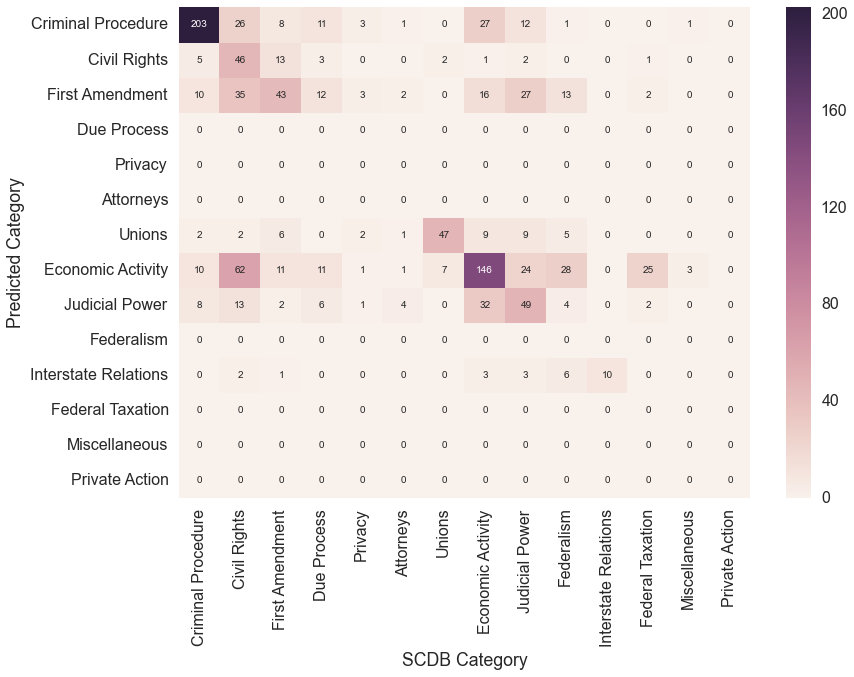

In [16]:
compare_mat_new = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(new_clusters, train_issue_areas):
    compare_mat_new[i][j] += 1
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

The next heat map is similar, but normalizes each column to have a sum of 1. In other words, the element in row `i` and column `j` represents the proportion of cases from SCDB category `j` that get placed in category `i` by the NMF clustering algorithm.

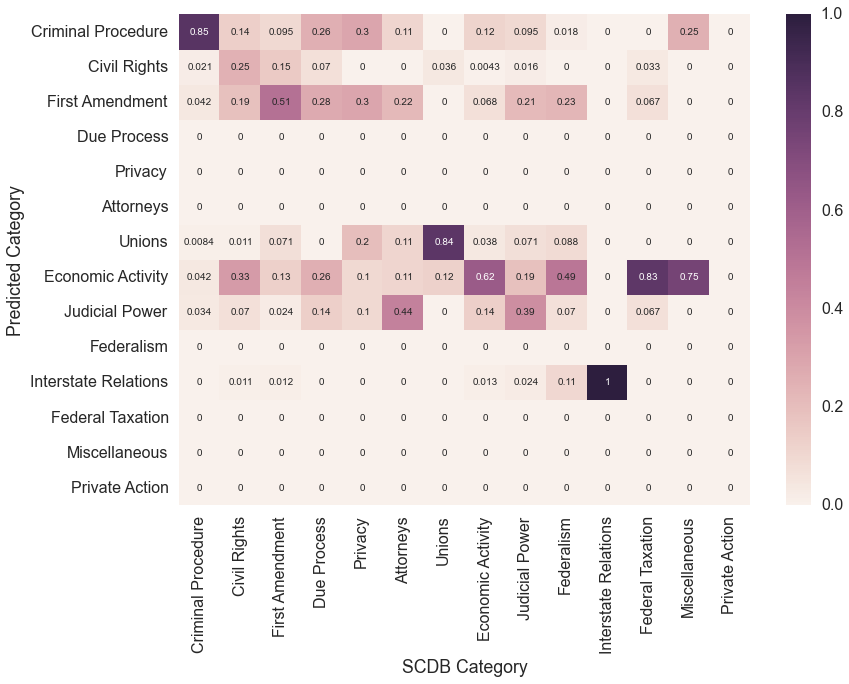

In [17]:
# normalize each column to have a sum of 1
compare_mat_new = np.array(compare_mat_new).T
compare_mat_new = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_new))
compare_mat_new = np.array(compare_mat_new).T

# produce a heat map of the new normalized matrix
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

The heat map gives some useful information about the errors that the NMF algorithm above tends to make most frequently. For example, many civil rights and federal taxation cases get mis-classified as economic activity cases; many due process cases get mis-classified as first amendment or civil rights cases; and many attorneys cases get mis-classified as judicial power cases.

The following bar graph displays the accuracy rate of the NMF clustering for the cases within each SCDB category, for the training data.

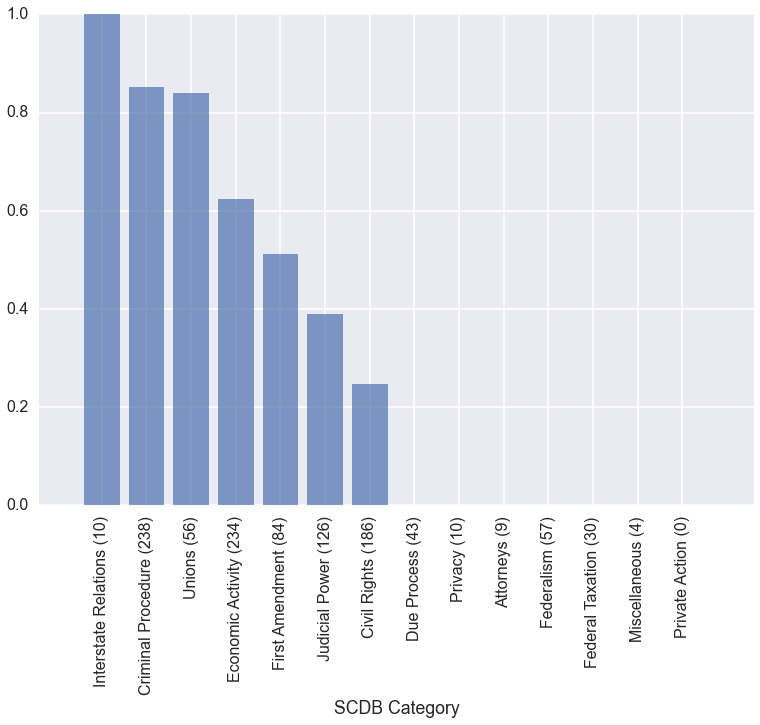

In [18]:
# sort the SCDB topic areas based on accuracy on training data
ordered = zip(topic_areas, [sum([x==i for x in train_issue_areas]) for i in range(14)], np.diag(compare_mat_new), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)
ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

This bar chart has both good and bad news. The NMF algorithm tends to do well for many of the categories; in particular, it does reasonably well on most of the largest categories, such as criminal procedures and economic activity. Unfortunately, the accuracy is much lower for some other categories, and there are several categories that have a 0% accuracy rate because the algorithm assigns zero cases to those categories.

##Cross-Validation

So far, we have only used 14 clusters in the NMF fit, and we have fit and tested the model on all the training data. To be more rigorous, we need to make two changes:
1. We need to choose the optimal number of clusters to start with in the unsupervised algorithm, before ultimately assigning each case (and more generally, each NMF cluster) to an SCDB category.
2. In particular, we should use some sort of validation to choose that optimal parameter value. In this case, we use 5-fold cross-validation.

The `cv_results_unsupervised` function takes 4 (or 5) arguments:
1. `predict`: a function that takes training data for $x$-values (a corpus matrix), training data for $y$-values (SCDB categories), and the test data for $x$-values (a test data corpus matrix), and produces a vector of predictions for the test data
2. `x`: a matrix of corpus data from the training set
3. `y`: a vector of SCDB categories for the cases in the training set
4. `score_func`: a function that takes a vector of predictions and a vector of actual SCDB categories and outputs some 'score' measure
5. `nfolds`: the number of folds for cross-validation, which is set to 5 by default

The function outputs a list of results of the score function, across all `n_folds` iterations.

In [22]:
def cv_results_unsupervised(predict, x, y, score_func, nfolds=5):
    results = []
    for train, test in KFold(len(y), nfolds):
        pred = predict(x[train],y[train],x[test]) # compute predictions
        results += [score_func(pred, y[test])] # evaluate score function on held-out data
    return results

The `fit_transform` function fits an NMF model with `n_components` clusters on the data in `x_train` and `y_train`, and use that to predict clusters for `x_test`. (Since NMF is unsupervised, the data in `y_train` is only used to create a mapping from NMF clusters to SCDB clusters, not to actually fit the model.)

In [26]:
def fit_transform(x_train, y_train, x_test, n_components):
    # compute an NMF fit on x_train, and produce
    fit = sklearn.decomposition.NMF(n_components=n_components, init='nndsvda').fit(x_train)
    W_train = fit.transform(x_train)
    clusters_train = map(np.argmax, W_train)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_components,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters_train, y_train):
        compare_mat[i][j] += 1
    assignments = map(np.argmax, compare_mat)
    
    W_test = fit.transform(x_test)
    clusters_test = map(np.argmax, W_test)
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters_test)
    return new_clusters

This is the cross-validation loop, which tests several different possible values of `n_clusters` using 5-fold cross-validation. We use the `fit_transform` function from above to predict, and the score function `score_func` is a tuple of the prediction accuracy and the Rand Index.

In [25]:
%%time
num_clusters_lst = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

results = dict()
for k in num_clusters_lst:
    print 'Testing with %d clusters' % k
    results[k] = cv_results_unsupervised(lambda x,y,z : fit_transform(x,y,z,k), noun_train_mat, train_issue_areas,
                                         lambda pred,act : (accuracy(pred,act), rand_index(pred,act)), nfolds=5)

Testing with 5 clusters
Testing with 10 clusters
Testing with 15 clusters
Testing with 20 clusters
Testing with 25 clusters
Testing with 30 clusters
Testing with 35 clusters
Testing with 40 clusters
Testing with 45 clusters
Testing with 50 clusters
Wall time: 59min 40s


In [28]:
# output 2 dictionaries containing the average accuracy and average Rand Index for each value of n_clusters, based on the
# cross-validation results from above
results_accuracies = dict()
results_rand_ind = dict()
for k in results.keys():
    accuracy_k, rand_index_k = zip(*results[k])
    results_accuracies[k] = np.mean(accuracy_k)
    results_rand_ind[k] = np.mean(rand_index_k)
print results_accuracies
print results_rand_ind

{35: 0.49764934680590206, 5: 0.4378768020969856, 40: 0.48207838329176, 10: 0.46172578531264535, 45: 0.48846657929226733, 15: 0.49123155625079279, 50: 0.50596541664905081, 20: 0.49118927831564713, 25: 0.48106794064177905, 30: 0.49397116644823064}
{35: 0.75952458809582646, 5: 0.66749798413003247, 40: 0.75769849213053331, 10: 0.73717176511222893, 45: 0.76328322379484914, 15: 0.77671859372916785, 50: 0.77692147151401725, 20: 0.77216563028945062, 25: 0.76275710596632429, 30: 0.76414665512708246}


To help us visualize which cluster count produces higher accuracy rates and Rand Index values, we can construct a line plot depicting the relationship between the number of clusters and the average accuracy and Rand Index from cross-validation.

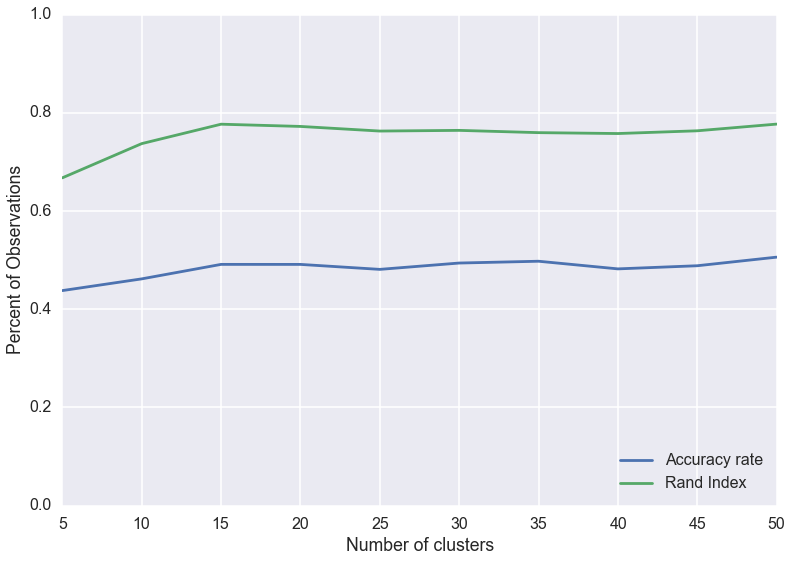

In [24]:
accuracies = results_accuracies.items()
accuracies.sort(key = lambda (a,b) : a)
plt.plot(*zip(*accuracies), label='Accuracy rate')

rand = results_rand_ind.items()
rand.sort(key = lambda (a,b) : a)
plt.plot(*zip(*rand), label='Rand Index')

plt.ylim((0,1))
plt.xlabel('Number of clusters')
plt.ylabel('Percent of Observations')
plt.legend(loc = 'lower right')

##Choose Best Model and Run on Test Data

###Choose Optimal Number of Clusters

Now, we can use the cross-validation results to choose the number of clusters. There are two possible ways to do this, which both assigned `n_clusters=50` when we ran the code. It would probably make more sense to use the accuracy rate, since that is the most easily interpretable measure of prediction accuracy.

####Option 1: Choose optimal n_clusters using average accuracy rate

In [30]:
n_clusters = results_accuracies.keys()[np.argmax(results_accuracies.values())]
n_clusters

50

####Option 2: Choose optimal n_clusters using average Rand Index

In [30]:
n_clusters = results_rand_ind.keys()[np.argmax(results_rand_ind.values())]
n_clusters

50

###Fit Model with Optimal Parameter and Apply to Test Data

Now, we can load in the corpus for the test data, and use the TF-IDF fit from the training data to transform that into a new data matrix. (We have to use the TF-IDF fit from the training set rather than re-computing the fit, in order to maintain the integrity of the training-test split.)

In [28]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 13.3 s


Now, we can use the `fit_transform` function from above, using the optimal number of clusters (which was 50 when we ran this), to cluster each case in the test data into one of the SCDB categories using an NMF model fit from the training data.

In [32]:
%%time
# vector of predicted SCDB categories for each element of the test set
clusters_test = fit_transform(noun_train_mat, train_issue_areas, noun_test_mat, n_clusters)
# list of lists of the cases that got clustered into each of the 14 categories
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(cluster_lists_test[i]) for i in range(14)]

Number of documents per cluster: [183, 74, 11, 0, 0, 0, 42, 131, 39, 11, 11, 6, 0, 0]
Wall time: 2min 29s


###Evaluate Test Data Results Using SC Database Categories

Using the test data clusters above, we can compute the accuracy and Rand Index for the test data predictions.

In [33]:
# read in SC Database's issue areas from csv
test_issue_areas = np.loadtxt("test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
test_issue_areas = test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 97, 38, 15, 3, 6, 26, 104, 68, 24, 5, 17, 1, 0]


In [34]:
# compute and output accuracy rate and Rand Index
print 'Accuracy:', accuracy(clusters_test, test_issue_areas)
print 'Rand Index:', rand_index(clusters_test, test_issue_areas)

Accuracy: 0.474409448819
Rand Index: 0.753751007502


This is a heat map of the same format as above, in which the element at row `i` and column `j` is the number of cases from SCDB category `j` that were classified as category `i`. (As before, this represents a correct categorization if and only if `i==j`.)

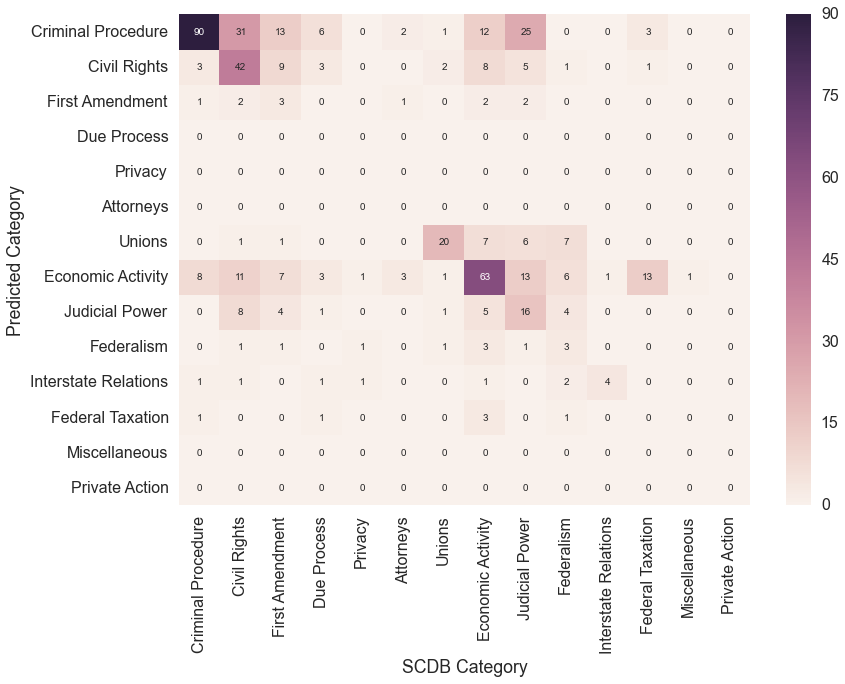

In [35]:
compare_mat_test = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(clusters_test, test_issue_areas):
    compare_mat_test[i][j] += 1

sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

This heat map is the same as above, but with each column normalized to have a sum of 1.

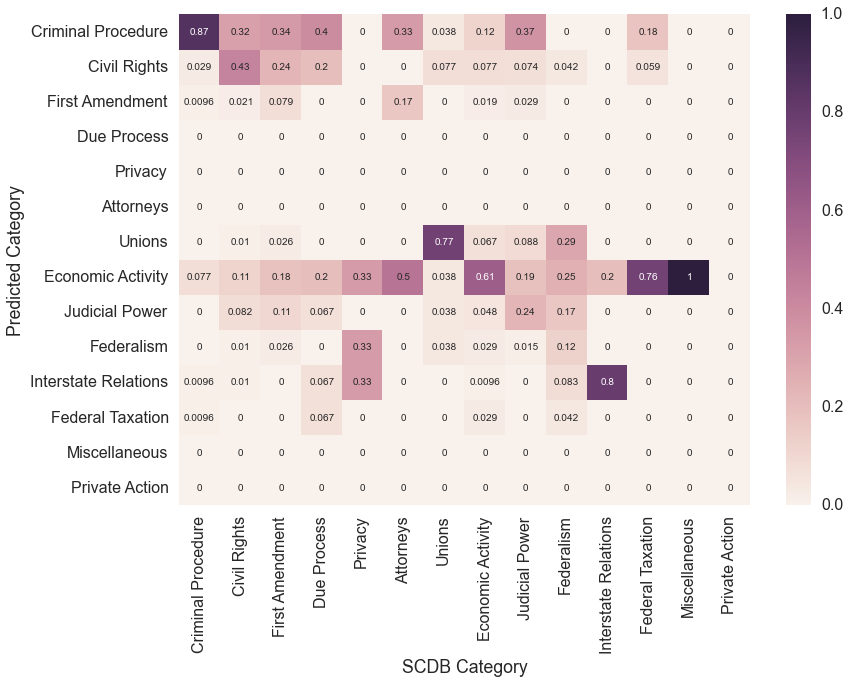

In [36]:
# normalize each column to have a sum of 1
compare_mat_test = np.array(compare_mat_test).T
compare_mat_test = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_test))
compare_mat_test = np.array(compare_mat_test).T

# produce a heat map in which the element in row i and column j represent the proportion of cases in the testing set from SCDB
# category j that get placed in category i by the clustering algorithm (trained on the training data with the optimal parameter)
sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

The sources of errors are similar to what they were for the training data. For instance, taxation cases tend to get mis-classified as economic activity, and due process cases tend to be mis-classified as criminal procedure or civil rights cases.

As before, the next bar graph shows the accuracy rate of the NMF clustering for the cases within each SCDB category, now for the test data.

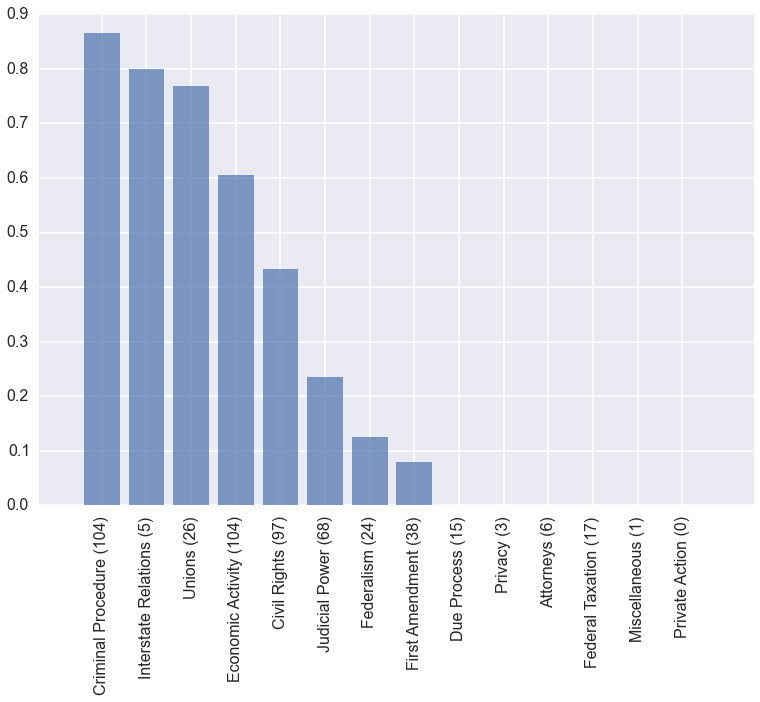

In [37]:
# sort the SCDB topic areas based on accuracy on testing data
ordered = zip(topic_areas, [sum([x==i for x in test_issue_areas]) for i in range(14)], np.diag(compare_mat_test), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)
ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

The results here are similar to the bar chart for the training data above. As before, the algorithm does well for the cases in most of the prominent categories (like criminal procedure and economic activity) in the test set. The performance for many of the smaller topic areas is weaker. However, the performance is better than the first bar chart, largely due to cross-validation; for example, we now have a nonzero accuracy rate for cases in the federalism category.

##Trying Other Parts of Speech

Finally, all of the work above focuses exclusively on nouns, but it's worth trying other parts of speech as well. We have corpuses for verbs, adjectives, foreign words, and precedents, and can try any of those on their own or in combination with others.

To do this, we want a convenient shorthand way to fit a model, predict clusters, and evaluate the quality of a prediction, for any given combination of parts of speech. To do, we have written an `evaluate` prediction that takes the following inputs:
1. `x_files`: a list of csv's to read in corpuses from. Those corpuses are subsequently concatenated together horizontally, in order to put all of the features together.
2. `y_data`: a vector of Supreme Court Database categories
3. `n_clusters`: number of clusters to use for the NMF fit

The function outputs a tuple containing the accuracy and Rand Index for the model predictions.

In particular, since we're just briefly evaluating these parts of speech to see if any of them offer a significant improvement over nouns alone, we can just train and test the data on a single set of training data instead of going through the full process of fitting models with cross-validation to find optimal parameters and evaluating the result on test data.

In [38]:
def evaluate(x_files, y_data, n_clusters):
    # read in text data
    x_data = map(lambda x_file : np.loadtxt(x_file, delimiter=','), x_files)
    x_data = reduce(lambda x1,x2 : np.concatenate((x1,x2),1), x_data)
    
    # use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
    tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(x_data)
    x_data = tf_idf_fit.transform(x_data).toarray()
    
    # compute NMF fit
    NMF_fit = sklearn.decomposition.NMF(n_components=n_clusters, init='nndsvda').fit(x_data)
    H = NMF_fit.components_
    W = NMF_fit.transform(x_data)
    # list of cluster assignments for the cases
    clusters = map(np.argmax, W)
    
    # create a (n_clusters x 14) matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the
    # degree of related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_clusters,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters, y_data):
        compare_mat[i][j] += 1
    # normalize each row to have a sum of 1
    compare_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat))

    # assign each NMF cluster to a SCDB cluster by picking the highest element of each row of compare_mat
    assignments = map(np.argmax, compare_mat)
    
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters)
    
    return (accuracy(new_clusters, y_data), rand_index(new_clusters, y_data))

First, we can evaluate each of the other parts of speech on their own.

In [44]:
%%time
evaluate(['verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1min 24s


(0.39282428702851885, 0.7066002916461078)

In [55]:
%%time
evaluate(['adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 16 s


(0.37994480220791166, 0.6703061776332995)

In [56]:
%%time
evaluate(['for_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 3.87 s


(0.27230910763569455, 0.361533689526384)

In [57]:
%%time
evaluate(['prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 21.3 s


(0.33854645814167433, 0.683244905714351)

Clearly, the other parts of speech are individually not nearly as good as nouns. This makes sense because most of the functional words describing the specific facts of each case would be nouns, while other parts of speech like verbs and adjectives are probably more generic.

So, any reasonable NMF-based model should include nouns. We can try pairing nouns with verbs, adjectives, and precedents in turn, since those three parts of speech did have some decent predictive power alone.

In [41]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 5min


(0.5390984360625575, 0.7776651215460121)

In [42]:
%%time
evaluate(['noun_train_mat.csv','adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 3min 47s


(0.5206991720331187, 0.7647263934649605)

In [43]:
%%time
evaluate(['noun_train_mat.csv','prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 3min 40s


(0.5271389144434223, 0.7688801923544033)

None of those pairs produces an accuracy rate that is significantly higher than nouns alone, since the nouns alone had an accuracy around 50% while these pairs all produce an accuracy rate below 54% (when we ran this). Because including many more variables makes the problem much more computationally difficult (especially with cross-validation) and runs a higher risk of over-fitting, we have decided that the model that was validated and tested above (with just nouns) is still superior, and that it is not worth conducting detailed cross-validation and testing on these paired models.

Finally, we can test all of the five parts of speech together, to see if that has greater predictive power.

In [40]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv','adj_train_mat.csv','for_train_mat.csv','prec_train_mat.csv'],
         train_issue_areas, n_clusters=n_clusters)

Wall time: 4min 22s


(0.546458141674333, 0.7942464638121007)

This had an accuracy rate around 54.6% on the training data when we ran it. Once again, this does offer some minor improvement over using nouns alone; however, this relatively minuscule accuracy improvement is not worth the massive number of features we would be adding, for the reasons described above.